In [37]:
import duckdb
import pandas as pd
from deltalake import DeltaTable
import boto3
import subprocess
import sys
import matplotlib.pyplot as plt

# ============================================================
# Cấu hình kết nối MinIO (qua DuckDB)
# ============================================================
print("🔗 Đang cấu hình kết nối tới MinIO...")

duckdb.sql("""
INSTALL httpfs;
LOAD httpfs;

SET s3_region='us-east-1';
SET s3_url_style='path';
SET s3_endpoint='127.0.0.1:9000';
SET s3_use_ssl=false;
SET s3_access_key_id='minioadmin';
SET s3_secret_access_key='minioadmin';
""")

print("✅ Cấu hình MinIO thành công.\n")

# ============================================================
# Đường dẫn Delta Lake
# ============================================================
bucket = "real-estate"
prefix = "lake/bronze/property/"
endpoint_url = "http://127.0.0.1:9000"

# ============================================================
# Liệt kê danh sách file .parquet trong MinIO (không dùng ký tự `*`)
# ============================================================
print("📁 Đang liệt kê các file Parquet thực tế...")

s3 = boto3.client(
    "s3",
    endpoint_url=endpoint_url,
    aws_access_key_id="minioadmin",
    aws_secret_access_key="minioadmin",
    region_name="us-east-1",
)

objects = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
parquet_files = [
    f"{endpoint_url}/{bucket}/{obj['Key']}"
    for obj in objects.get("Contents", [])
    if obj["Key"].endswith(".parquet")
]

# if not parquet_files:
#     print("⚠️ Không tìm thấy file Parquet nào trong MinIO.")

# else:
#     print(f"✅ Tìm thấy {len(parquet_files)} file Parquet:")
#     for f in parquet_files:
#         print("-", f)
#     print()

🔗 Đang cấu hình kết nối tới MinIO...
✅ Cấu hình MinIO thành công.

📁 Đang liệt kê các file Parquet thực tế...


In [38]:
# ============================================================
# Đọc metadata Delta Lake
# ============================================================
print("📁 Đang đọc metadata Delta Lake...")

dt = DeltaTable(
    "s3a://real-estate/lake/bronze/property",
    storage_options={
        "AWS_ACCESS_KEY_ID": "minioadmin",
        "AWS_SECRET_ACCESS_KEY": "minioadmin",
        "AWS_ENDPOINT_URL": endpoint_url,
        "AWS_ALLOW_HTTP": "true"
    }
)

# print(f"📦 Version hiện tại của Delta Lake: {dt.version()}")
# print("📄 Các file parquet hiện có:")
# print(dt.files())
# print()


📁 Đang đọc metadata Delta Lake...


In [39]:
# # ============================================================
# # Truy vấn DuckDB với danh sách file cụ thể
# # ============================================================
# print("\n🔍 Đang truy vấn DuckDB với danh sách file cụ thể...")

# try:
#     # Chúng ta dùng '?' để truyền biến Python (params) vào SQL
#     # Cần dấu ngoặc kép "..." quanh tên cột vì nó có chữ hoa/thường
#     result_df = duckdb.sql(
#         'SELECT "propertyDetails_propertyId" FROM read_parquet(?)',
#         params=[parquet_files]  
#     ).df()

#     print("✅ Truy vấn thành công!")
#     print(f"Tìm thấy {len(result_df)} dòng.")
#     print("\n--- 5 dòng đầu tiên ---")
#     print(result_df.head())

# except Exception as e:
#     print(f"❌ Lỗi khi truy vấn DuckDB: {e}")

# # ============================================================
# # Truy vấn SQL
# # ============================================================
# property_id = result_df['propertyDetails_propertyId'].sample(n=1).iloc[0]
# query = f"""
# SELECT propertyDetails_propertyId, url, latitude, longitude
# FROM read_parquet({parquet_files})
# WHERE propertyDetails_propertyId = '{property_id}'
# """
# filtered = duckdb.sql(query).df()
# print(f"🔍 Dữ liệu của propertyDetails_propertyId = {property_id}:")
# print(filtered)
# print()

In [40]:
# # ============================================================
# # Truy vấn SQL tương thích với schema mới (8 cột)
# # ============================================================
# property_id = result_df['propertyDetails_propertyId'].sample(n=1).iloc[0]
# query = f"""
# SELECT propertyDetails_propertyId, "Mức giá", "Diện tích", "Địa chỉ", url, latitude, longitude
# FROM read_parquet({parquet_files})
# WHERE propertyDetails_propertyId = '{property_id}'
# """
# filtered = duckdb.sql(query).df()
# print(f"🔍 Dữ liệu của propertyDetails_propertyId = {property_id}:")
# print(filtered)
# print()

In [41]:
# # ============================================================
# # Truy vấn SQL tương thích với schema mới (8 cột)
# # ============================================================
# import pandas as pd

# # Hiển thị đầy đủ nội dung các cột
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.width", 0)

# property_id = result_df['propertyDetails_propertyId'].sample(n=1).iloc[0]

# query = f"""
# SELECT propertyDetails_propertyId,
#        "Mức giá",
#        "Diện tích",
#        "Địa chỉ",
#        "Tiêu đề",
#        url,
#        latitude,
#        longitude
# FROM read_parquet({parquet_files})
# WHERE propertyDetails_propertyId = '{property_id}'
# """

# filtered = duckdb.sql(query).df()

# print(f"🔍 Dữ liệu chi tiết của propertyDetails_propertyId = {property_id}:")
# print("=" * 120)
# print(filtered.to_string(index=False))   # In toàn bộ nội dung từng cột không bị rút gọn
# print("=" * 120)
# print(f"✅ Tổng số dòng: {len(filtered)}")
# print()


In [42]:
# # ============================================================
# # DESCRIBE HISTORY (Lịch sử Delta)
# # ============================================================
# print("🕒 DESCRIBE HISTORY (Lịch sử thay đổi bảng):")
# try:
#     history = dt.history()
#     if history:
#         for h in history:
#             print(f"Version {h['version']}: {h['timestamp']} - {h['operation']}")
#     else:
#         print("⚠️ Không có thông tin lịch sử (Delta log trống).")
# except Exception as e:
#     print(f"⚠️ Lỗi khi đọc lịch sử: {e}")
# print()


In [43]:
# # ============================================================
# # Đọc dữ liệu qua DuckDB
# # ============================================================
# print("📦 Đang đọc dữ liệu từ MinIO (DuckDB)...")
# try:
#     # Tạo DataFrame 'df' bằng cách đọc TẤT CẢ CỘT
#     df = duckdb.sql("SELECT * FROM read_parquet(?) ", params=[parquet_files]).df()
#     print(f"✅ Đọc thành công {len(df)} dòng dữ liệu.")
#     print("📋 Các cột có sẵn:")
#     print(f"{df.columns.tolist()}")
#     print("\n📊 Thống kê mô tả:")
#     print(df.describe(include='all').transpose())
#     print()
# except Exception as e:
#     print(f"❌ Lỗi khi đọc dữ liệu: {e}")


📊 Đang vẽ biểu đồ số lượng theo thành phố...


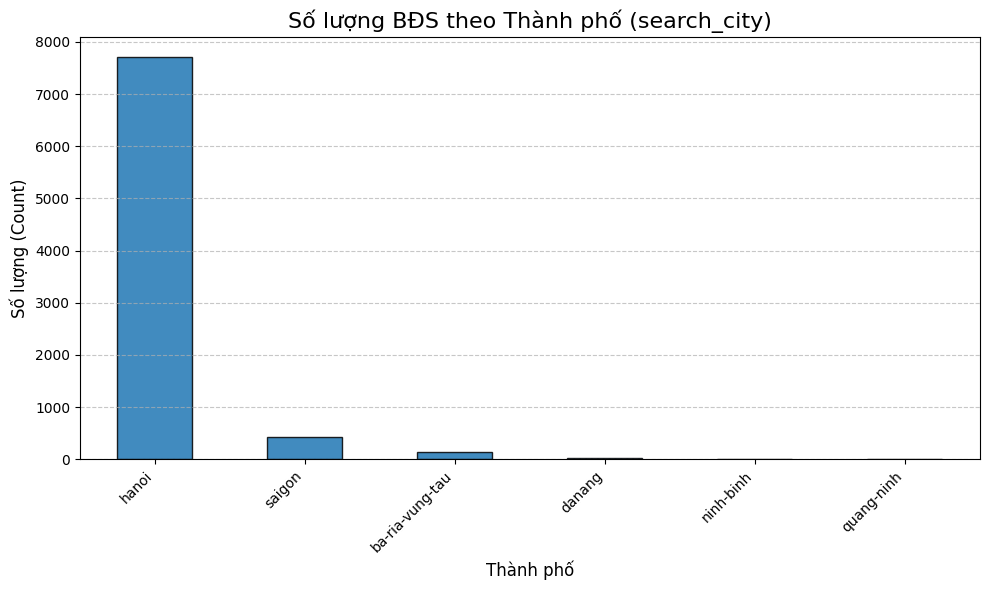

In [44]:
# ============================================================
# 📊 Biểu đồ Cột: Số lượng theo Thành phố (search_city)
# ============================================================
print("\n📊 Đang vẽ biểu đồ số lượng theo thành phố...")

# Kiểm tra xem biến 'df' đã tồn tại, không rỗng, và có cột 'search_city' chưa
if 'df' in locals() and not df.empty and 'search_city' in df.columns:
    # Đếm số lượng của mỗi thành phố
    city_counts = df['search_city'].value_counts()
    
    if not city_counts.empty:
        plt.figure(figsize=(10, 6)) # Tạo khung hình
        city_counts.plot(kind='bar', alpha=0.85, edgecolor='black')
        plt.title('Số lượng BĐS theo Thành phố (search_city)', fontsize=16)
        plt.xlabel('Thành phố', fontsize=12)
        plt.ylabel('Số lượng (Count)', fontsize=12)
        plt.xticks(rotation=45, ha='right') # Xoay nhãn trục X
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout() # Tự căn chỉnh
        plt.show() # Hiển thị biểu đồ
    else:
        print("⚠️ Cột 'search_city' không có dữ liệu.")
else:
    print("⚠️ Không tìm thấy DataFrame 'df' hoặc cột 'search_city'. Hãy chạy cell trên để tải dữ liệu.")


📈 Đang vẽ biểu đồ phân phối vĩ độ...


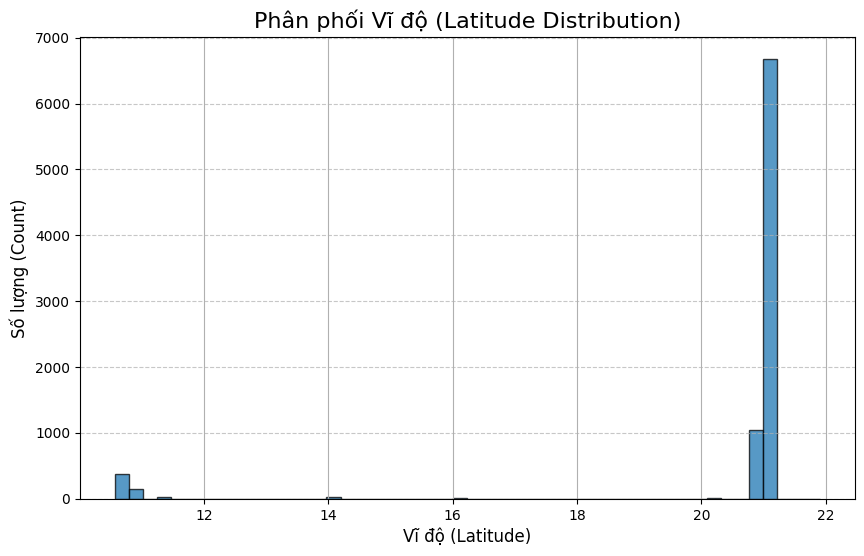

In [45]:
# ============================================================
# 📈 Biểu đồ Histogram: Phân phối Vĩ độ (latitude)
# ============================================================
print("\n📈 Đang vẽ biểu đồ phân phối vĩ độ...")

if 'df' in locals() and not df.empty and 'latitude' in df.columns:
    # Đảm bảo là dạng số và loại bỏ NaN
    latitudes = pd.to_numeric(df['latitude'], errors='coerce').dropna()
    
    if not latitudes.empty:
        plt.figure(figsize=(10, 6))
        latitudes.hist(bins=50, alpha=0.75, edgecolor='black')
        plt.title('Phân phối Vĩ độ (Latitude Distribution)', fontsize=16)
        plt.xlabel('Vĩ độ (Latitude)', fontsize=12)
        plt.ylabel('Số lượng (Count)', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("⚠️ Cột 'latitude' không có dữ liệu số hợp lệ.")
else:
    print("⚠️ Không tìm thấy DataFrame 'df' hoặc cột 'latitude'.")